# Imports

In [2]:
import pandas as pd
import numpy as np
import GEOparse
import os
import seaborn as sns
from dotenv import load_dotenv
from pathlib import Path
from sklearn.impute import KNNImputer

import matplotlib.pyplot as plt

# Download Dataset
First step is to download the dataset, extract the metadata and drop constant columns (contain no information, only slow down computations).

In [3]:
# Step 1: Download GEO dataset
gse = GEOparse.get_GEO("GSE96058", destdir="/Users/sarah/Code/bioinformatics-tool/backend/data", how="full", silent=True)

# Step 2: Extract sample metadata (GSMs)
clinical_df = gse.phenotype_data

n_before = clinical_df.shape[1]
clinical_df = clinical_df.loc[:, clinical_df.nunique(dropna=False) > 1].copy()
n_after = clinical_df.shape[1]

print(f"Dropped {n_before - n_after} constant columns. Remaining columns: {n_after}")

# Set 'title' as index
clinical_df.set_index("title", inplace=True)


Dropped 26 constant columns. Remaining columns: 31


First overlook over data showed "NA" as a string in columns -> we want to replace it with np.nan globally. 

In [4]:
# using np for NaN replacement
clinical_df.replace("NA", np.nan, inplace=True)


Getting an overlook over what columns we have available.

In [5]:
for col in clinical_df.columns:
    print(col)


geo_accession
last_update_date
characteristics_ch1.0.scan-b external id
characteristics_ch1.1.instrument model
characteristics_ch1.2.age at diagnosis
characteristics_ch1.3.tumor size
characteristics_ch1.4.lymph node group
characteristics_ch1.5.lymph node status
characteristics_ch1.6.er status
characteristics_ch1.7.pgr status
characteristics_ch1.8.her2 status
characteristics_ch1.9.ki67 status
characteristics_ch1.10.nhg
characteristics_ch1.11.er prediction mgc
characteristics_ch1.12.pgr prediction mgc
characteristics_ch1.13.her2 prediction mgc
characteristics_ch1.14.ki67 prediction mgc
characteristics_ch1.15.nhg prediction mgc
characteristics_ch1.16.er prediction sgc
characteristics_ch1.17.pgr prediction sgc
characteristics_ch1.18.her2 prediction sgc
characteristics_ch1.19.ki67 prediction sgc
characteristics_ch1.20.pam50 subtype
characteristics_ch1.21.overall survival days
characteristics_ch1.22.overall survival event
characteristics_ch1.23.endocrine treated
characteristics_ch1.24.chemo 

# Data Preprocessing

Preprocessing of the features that remain:
- Numeric Features: leave as is, possibly standardize later
- Binary Features: map to 0/1
- Ordinal Categorical (e.g. nhg): map to 1,2,3
- Nominal categorical (e.g. pam50 subtype): one-hot encode -> so we don't introduce an artificial order


In [6]:

clinical_df_cleaned = clinical_df.copy()

# Clean up column names
clinical_df_cleaned.columns = clinical_df_cleaned.columns.str.replace(r'^characteristics_ch1\.\d+\.', '', regex=True)


## Columns to Drop
- identifiers
- duplicates

In [7]:
cols_to_drop = ['sample_id', 'geo_accession', 'scan-b external id', 'relation']

# Drop only if they exist (to avoid errors)
clinical_df_cleaned = clinical_df_cleaned.drop(columns=[col for col in cols_to_drop if col in clinical_df_cleaned.columns])

### Instrument Model
This is a feature that would be excluded before ML application but could be interesting during EDA (e.g. batch effects) and that is why I want to keep it for now. There are however three columns that seem to have the same consistent values with the same information ('instrument model', 'platform id' and 'instrument_model') so I check whether they have 100% match and if so, drop two of them and retain only one.

In [8]:
instrument_pairs = clinical_df_cleaned[['instrument model', 'platform_id']].dropna()
mapping_check = instrument_pairs.groupby('instrument model')['platform_id'].nunique()
print(mapping_check[mapping_check > 1])


Series([], Name: platform_id, dtype: int64)


In [9]:
instrument_pairs = clinical_df_cleaned[['instrument model', 'instrument_model']].dropna()
mapping_check = instrument_pairs.groupby('instrument model')['instrument_model'].nunique()
print(mapping_check[mapping_check > 1])


Series([], Name: instrument_model, dtype: int64)


Since none map to more than one platform id / model, I can drop two cols.

In [10]:
clinical_df_cleaned = clinical_df_cleaned.drop(columns=['platform_id', 'instrument_model'])

## Numeric Columns
no preprocessing necessary apart from transformation to numeric

In [11]:
numeric_cols = [
    'age at diagnosis',
    'tumor size',
    'overall survival days'
]


In [12]:
for col in numeric_cols:
    try:
        clinical_df_cleaned[col] = pd.to_numeric(clinical_df_cleaned[col], errors='coerce')
    except Exception as e:
        print(f"Couldn't convert {col}: {e}")


## Binary Columns
Binary columns are encoded in different ways. They should all numerically be 0 or 1 or NaN after preprocessing.

In [13]:
# Encode lymph node status
clinical_df_cleaned['lymph node status'] = clinical_df_cleaned['lymph node status'].map({
    'NodeNegative': 0,
    'NodePositive': 1
})


In [14]:
binary_cols = ['er status', 'pgr status', 'her2 status', 'ki67 status', 'er prediction mgc', 'pgr prediction mgc', 'her2 prediction mgc', 'ki67 prediction mgc', 'er prediction sgc', 'pgr prediction sgc', 'her2 prediction sgc', 'ki67 prediction sgc', 'overall survival event', 'endocrine treated', 'chemo treated']

# Replace 'NA' strings with np.nan and convert to float
for col in binary_cols:
    clinical_df_cleaned[col] = clinical_df_cleaned[col].replace('NA', np.nan).astype(float)


## Ordinal Columns
Label encode -> preserve order

To create a mapping, the different unique values are examined.

In [15]:
print(f"Nottingham Histologic Grades: {clinical_df_cleaned['nhg'].unique()}")
print(f"Nottingham Histologic Grades Prediction: {clinical_df_cleaned['nhg prediction mgc'].unique()}")
print(f"Lymph Node Group: {clinical_df_cleaned['lymph node group'].unique()}")

Nottingham Histologic Grades: ['G3' 'G2' 'G1' nan]
Nottingham Histologic Grades Prediction: ['G3' 'G2']
Lymph Node Group: ['NodeNegative' '1to3' '4toX' 'SubMicroMet' nan]


Comment: interesting thet the NHG Prediction MGC only has grade 2 and 3!

### Lymph Node Group
Not sure whether to one hot encode or label encode -  there is an implicit order (Node Negative < SubmicroMet y< 1to3 < 4toX) but since the boundaries are fuzzy (SubMicroMet), this could also be a problem - solution: for now, use label encoding and potentially later on if using NN go back and one-hot-encode.

In [16]:
ordinal_map = {
    'nhg': {'G1': 1, 'G2': 2, 'G3': 3},
    'nhg prediction mgc': {'G2': 2, 'G3': 3},
    'lymph node group': {'NodeNegative': 0, 'SubMicroMet': 1, '1to3': 2, '4toX': 3}
}

for col, mapping in ordinal_map.items():
    clinical_df_cleaned[col] = clinical_df_cleaned[col].replace('NA', np.nan)
    clinical_df_cleaned[col] = clinical_df_cleaned[col].map(mapping)


## Non-Ordinal Columns
One Hot Encode. Keep originals for now (might be useful for analyses).

In [17]:
cols_to_one_hot = ['last_update_date', 'instrument model', 'pam50 subtype']

# 1. Rename original columns with OG_ prefix
clinical_df_renamed = clinical_df_cleaned.rename(
    columns={col: f'OG_{col}' for col in cols_to_one_hot}
)

# 2. Generate one-hot columns, with OHE_ prefix
ohe = pd.get_dummies(
    clinical_df_cleaned[cols_to_one_hot],
    prefix=[f'OHE_{col}' for col in cols_to_one_hot],
    prefix_sep='__',
    dtype=int
)

# 3. Concatenate to original DataFrame (with OG_ columns)
clinical_df_combined = pd.concat([clinical_df_renamed, ohe], axis=1)

Second version without keeping originals and renaming (for webapp).

In [18]:
cols_to_one_hot = ['last_update_date', 'instrument model', 'pam50 subtype']

clinical_df_onehot = pd.get_dummies(clinical_df_cleaned, columns=cols_to_one_hot, prefix_sep='__', dtype=int)

# Flag Columns
I want to flag columns I will not be using for ML training but would still like to keep for ETA (since they might give useful information).
- identifiers
- technical metadata
- prediction outputs from papers

In [19]:
id_columns = [
    'last_update_date__Mar 12 2018',
    'last_update_date__May 04 2022',
    'instrument model__HiSeq 2000',
    'instrument model__NextSeq 500',
    "er prediction mgc",
    "pgr prediction mgc",
    "her2 prediction mgc",
    "ki67 prediction mgc",
    "nhg prediction mgc",
    "er prediction sgc",
    "pgr prediction sgc",
    "her2 prediction sgc",
    "ki67 prediction sgc"
]

prediction_columns = [
    col for col in clinical_df.columns if 'prediction' in col.lower()
]

excluded_columns = id_columns + prediction_columns

Before saving, I want to rename "title" to "sample_id", because that is what this column is called in the expression matrix dataset and I want to have them all named the same so it's easier to join and better in the db later.

# Export 

## Normal

In [ ]:
load_dotenv(dotenv_path="/Users/sarah/Code/bioinformatics-tool/analysis/.env") 

def find_repo_root(start_path: Path = None) -> Path:
    if start_path is None:
        start_path = Path().resolve()
    for parent in [start_path] + list(start_path.parents):
        if (parent / '.git').exists():
            return parent
    raise RuntimeError("Could not find repo root!")


repo_root = find_repo_root()



# Rename 'title' to 'sample_id' for clarity and consistency
if clinical_df_combined.index.name == "title":
    clinical_df_combined = clinical_df_combined.reset_index().rename(columns={"title": "sample_id"})

path = repo_root / os.getenv("CLINICAL")
# Save to CSV (now with 'sample_id' as the column name)
clinical_df_combined.to_csv(path,index=False)


## One-Hot Encoded

In [ ]:
load_dotenv(dotenv_path="/Users/sarah/Code/bioinformatics-tool/analysis/.env") 

def find_repo_root(start_path: Path = None) -> Path:
    if start_path is None:
        start_path = Path().resolve()
    for parent in [start_path] + list(start_path.parents):
        if (parent / '.git').exists():
            return parent
    raise RuntimeError("Could not find repo root!")


repo_root = find_repo_root()



# Rename 'title' to 'sample_id' for clarity and consistency
if clinical_df_onehot.index.name == "title":
    clinical_df_onehot = clinical_df_onehot.reset_index().rename(columns={"title": "sample_id"})

path = repo_root / os.getenv("CLINICAL_ONEHOT")
# Save to CSV (now with 'sample_id' as the column name)
clinical_df_onehot.to_csv(path,index=False)


# Imputation
Before imputing the missing values, I have a closer look at the missing data.

In [21]:
# Number of missing values per column
missing_counts = clinical_df_combined.isnull().sum()

# Percentage of missing values per column
missing_percent = clinical_df_combined.isnull().mean() * 100

# Combine both into a single DataFrame for easy viewing
missing_summary = pd.DataFrame({
    'missing_count': missing_counts,
    'missing_percent': missing_percent
}).sort_values(by='missing_percent', ascending=False)

missing_summary[missing_summary['missing_count'] > 0]

,missing_count,missing_percent
ki67 status,1818,53.329422
pgr status,358,10.501613
er status,220,6.453505
her2 status,128,3.754767
lymph node group,101,2.962746
lymph node status,101,2.962746
nhg,65,1.906718
tumor size,35,1.026694
endocrine treated,22,0.645351
chemo treated,21,0.616016


10 out of 26 columns have missing values, most are binary columns.

ki67 status is missing for 53%! 
Could argue for dropping this column, but Davey et al. 2021 found that "The expression of Ki-67 is strongly linked to tumour cell proliferation and growth and is routinely evaluated as a proliferation marker." -> keep


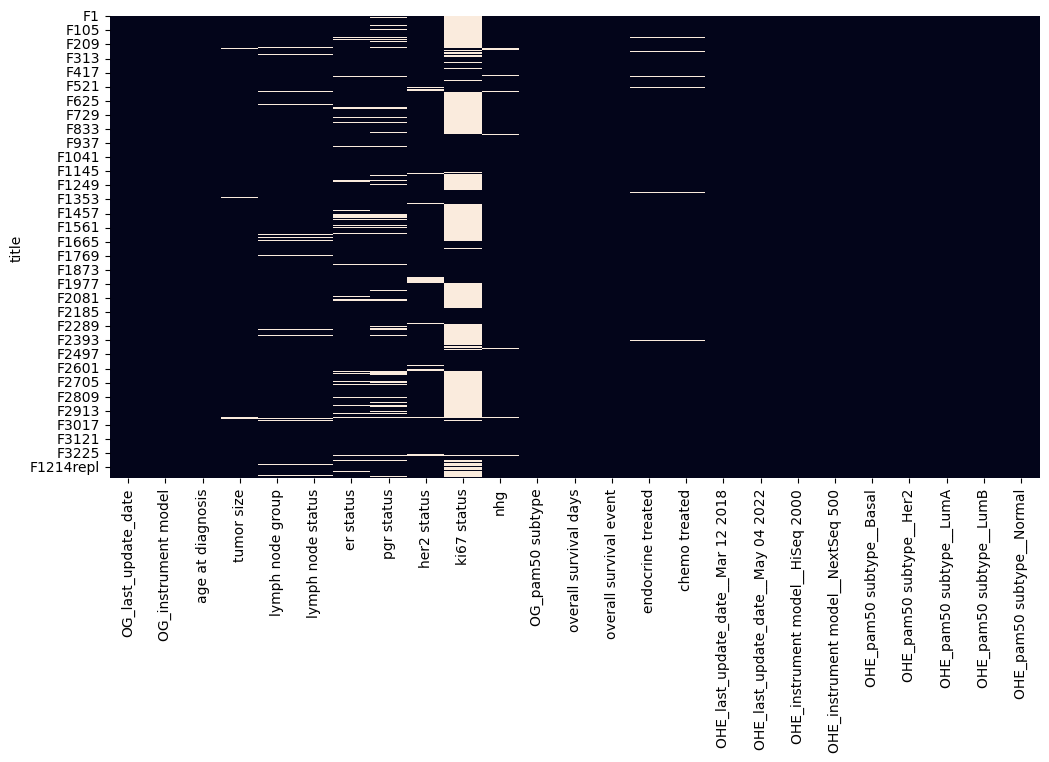

In [22]:
prediction_cols = [col for col in clinical_df_combined.columns if "prediction" in col.lower()]


clinical_no_predictions = clinical_df_combined.drop(columns=prediction_cols, errors='ignore')

plt.figure(figsize=(12,6))
sns.heatmap(clinical_no_predictions.isnull(), cbar=False)
plt.show()


Before the imputation, we remove all "prediction" columns, since I don't want to introduce any biases from the models that come from the original publication.

In [23]:
prediction_cols = [col for col in clinical_df_combined.columns if "prediction" in col.lower()]

# flag: 1 if measured (not missing), 0 if missing
clinical_df_combined['ki67_measured'] = clinical_df_combined['ki67 status'].notna().astype(int)

df_predict = clinical_df_combined[prediction_cols]
df_no_predict = clinical_df_combined.drop(columns=prediction_cols)


from sklearn.impute import KNNImputer

binary_cols = [
    'ki67 status', 'pgr status', 'er status', 'her2 status',
    'lymph node group', 'lymph node status', 'nhg', 
    'tumor size', 'endocrine treated', 'chemo treated'
]

imputer = KNNImputer(n_neighbors=5)
df_no_predict[binary_cols] = imputer.fit_transform(df_no_predict[binary_cols])
df_no_predict[binary_cols] = df_no_predict[binary_cols].round().astype(int)


df_final = pd.concat([df_no_predict, df_predict], axis=1)


## Exporting the Imputed Dataset

In [ ]:
load_dotenv(dotenv_path="/Users/sarah/Code/bioinformatics-tool/analysis/.env") 

def find_repo_root(start_path: Path = None) -> Path:
    if start_path is None:
        start_path = Path().resolve()
    for parent in [start_path] + list(start_path.parents):
        if (parent / '.git').exists():
            return parent
    raise RuntimeError("Could not find repo root!")


repo_root = find_repo_root()



# Rename 'title' to 'sample_id' for clarity and consistency
if df_final.index.name == "title":
    df_final = df_final.reset_index().rename(columns={"title": "sample_id"})

path = repo_root / os.getenv("CLINICAL_IMPUTED")
# Save to CSV (now with 'sample_id' as the column name)
df_final.to_csv(path,index=False)
